Import required packages

In [1]:
%pylab inline
import math, re, json, requests
from google.protobuf import json_format

Populating the interactive namespace from numpy and matplotlib


In [13]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [2]:
from google.transit import gtfs_realtime_pb2
import requests
import pandas as pd

In [3]:
from datetime import datetime
import time
from pytz import timezone

In [4]:
from translinkUtilities import convertColumnToType

# Position Updates

Import the data, remove those positions with faulty latlon, and add a human-readable `time` column.

In [78]:
positions = pd.DataFrame.from_csv('./PositionUpdates.csv', index_col=False)
# remove those positions with faulty Lat-Lon
positions = positions[positions['lat']!=0]
# add human-readable times
positions['time'] = positions['ts'].apply(lambda x: datetime.fromtimestamp(x))

In [79]:
positions.head()

,lat,lon,ts,tid,vid,time
0,49.261932,-123.168251,1498614448,9017966,9503,2017-06-27 18:47:28
1,49.274849,-123.138885,1498614448,9017991,9568,2017-06-27 18:47:28
2,49.285984,-123.120514,1498614448,9017964,9674,2017-06-27 18:47:28
3,49.253433,-123.167786,1498614448,9017992,9476,2017-06-27 18:47:28
4,49.234550,-123.185883,1498614448,9018032,9536,2017-06-27 18:47:28


In [80]:
positions.shape

(167330, 6)

Next, fix the `dtypes` to `category` for `vid` and `tid`.

In [81]:
convertColumnToType(positions, {'tid': 'category', 'vid': 'category'})

In [82]:
positions.dtypes

lat            float64
lon            float64
ts               int64
tid           category
vid           category
time    datetime64[ns]
dtype: object

## Make a plot

For generating custom colour maps

In [122]:
def colourMapBy(data, category, cmap='jet', alpha=None):
    lsc = plt.cm.get_cmap(cmap)
    cmap = lsc(np.linspace(0, 1, data[category].cat.categories.size), alpha)
    return cmap

In [83]:
lon_min = positions['lon'].min()
lon_max = positions['lon'].max()
lat_min = positions['lat'].min()
lat_max = positions['lat'].max()

### Plots by day

In [118]:
mask_j27 = positions['time'] < '2017-06-28'
mask_j28 = (positions['time'] >= '2017-06-28') & (positions['time'] < '2017-06-29')

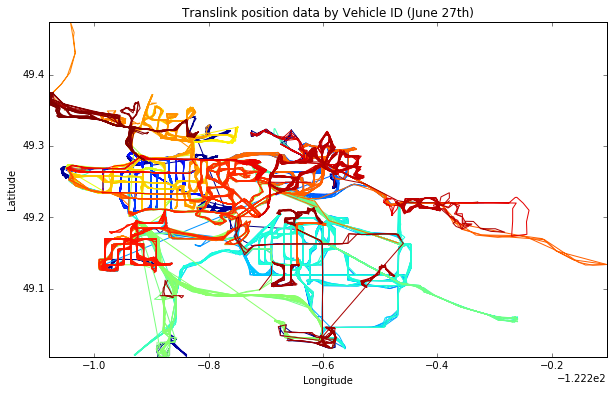

In [124]:
# settting a custom colour map
posns_j27 = positions.loc[mask_j27]
cmap_vid_j27 = colourMapBy(positions.loc[mask_j27], 'vid')

plt.figure(figsize=(10,6))
for j, (key, grp) in enumerate(posns_j27.groupby('vid')):
    plt.plot(grp['lon'], grp['lat'], '-', label=key, color=cmap_vid_j27[j, :]);
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max);
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Translink position data by Vehicle ID (June 27th)');

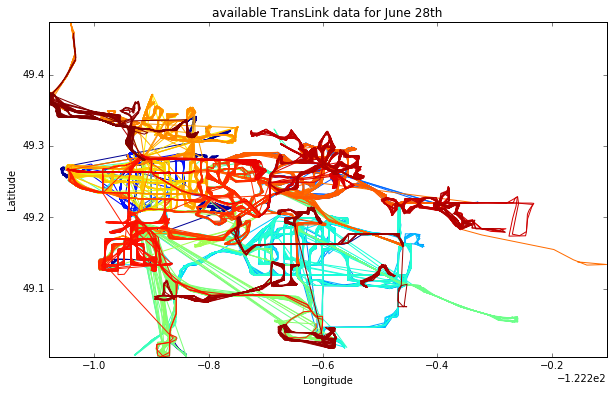

In [121]:
# settting a custom colour map
posns_j28 = positions.loc[mask_j28]
cmap_vid_j28 = colourMapBy(positions.loc[mask_j28], 'vid')

plt.figure(figsize=(10,6))
for j, (key, grp) in enumerate(posns_j28.groupby('vid')):
    plt.plot(grp['lon'], grp['lat'], '-', label=key, 
             color=cmap_vid_j28[j, :]);
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max);
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('available TransLink data for June 28th');

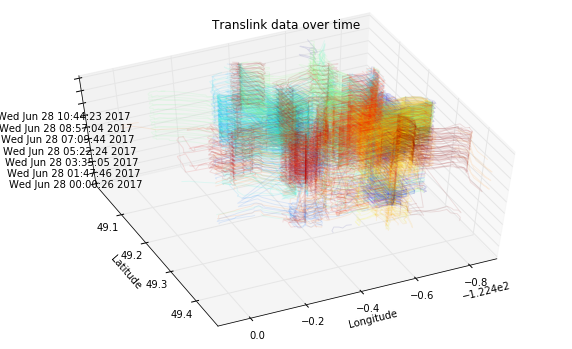

In [123]:
# settting a custom colour map
cmap_vid3d_j28 = colourMapBy(posns_j28, 'vid', alpha=.1)

zTickLabs = [datetime.fromtimestamp(np.round(t)).ctime() 
             for t in np.linspace(posns_j28['ts'].min(), 
                                  posns_j28['ts'].max(), 7)]

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
for j, (key, grp) in enumerate(posns_j28.groupby('vid')):
    ax.plot(grp['lon'].values, grp['lat'].values, grp['ts'].values, 
            color=cmap_vid3d_j28[j,:]);
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');
ax.set_zticklabels(zTickLabs)
plt.title('Translink data over time')
ax.view_init(55, 65);

## Interesting applications

Can we compute the intrinsic manifold dimension of Vancouver's transit system by looking at pairwise distances between vehicles?

Which ones are the Skytrains?

Can we use `stops.txt` to say anything about which stop the buses are at / build something that is more human-queryable using the fact that streetnames are listed in this file?

# Trip updates

URL and credential for Translink GTFS-Realtime

In [4]:
baseURL = 'http://gtfs.translink.ca/gtfsrealtime?apikey='
apikey = 'EuqbS0U1AatCOXictFZd'

In [5]:
feed = gtfs_realtime_pb2.FeedMessage()
response = requests.get(baseURL + apikey)

In [6]:
feed.ParseFromString(response.content)

In [7]:
for j in range(10):
    print('Entity {}'.format(j))
    print(feed.entity[j], end='\r')
    print()

Entity 0
id: "9032187"
trip_update {
  trip {
    trip_id: "9032187"
  }
  stop_time_update {
    departure {
      delay: 0
    }
    stop_id: "22"
  }
  vehicle {
    id: "9581"
    label: "9581"
  }
  timestamp: 1498604951
}

Entity 1
id: "9018039"
trip_update {
  trip {
    trip_id: "9018039"
  }
  stop_time_update {
    departure {
      delay: -120
    }
    stop_id: "29"
  }
  vehicle {
    id: "9568"
    label: "9568"
  }
  timestamp: 1498604951
}

Entity 2
id: "9046033"
trip_update {
  trip {
    trip_id: "9046033"
  }
  stop_time_update {
    departure {
      delay: 600
    }
    stop_id: "36"
  }
  vehicle {
    id: "9663"
    label: "9663"
  }
  timestamp: 1498604951
}

Entity 3
id: "9020703"
trip_update {
  trip {
    trip_id: "9020703"
  }
  stop_time_update {
    departure {
      delay: 0
    }
    stop_id: "48"
  }
  vehicle {
    id: "2109"
    label: "2109"
  }
  timestamp: 1498604951
}

Entity 4
id: "9017953"
trip_update {
  trip {
    trip_id: "9017953"
  }
  stop

In [8]:
feed.entity[0]

id: "9032187"
trip_update {
  trip {
    trip_id: "9032187"
  }
  stop_time_update {
    departure {
      delay: 0
    }
    stop_id: "22"
  }
  vehicle {
    id: "9581"
    label: "9581"
  }
  timestamp: 1498604951
}

In [9]:
trip_updates = [json_format.MessageToDict(entity.trip_update) 
                for entity in feed.entity 
                if entity.HasField('trip_update')]

In [21]:
def tryIntCoerce(x):
    try:
        x = int(x)
    except ValueError as ve:
        pass
    return x

In [22]:
def stripDelay(tu, verbose=False):
    try: 
        return {'departure_delay' : tryIntCoerce(tu['stopTimeUpdate'][0]['departure']['delay']),
                'stopId' : tryIntCoerce(tu['stopTimeUpdate'][0]['stopId']), 
                'timestamp' : tryIntCoerce(tu['timestamp']), 
                'tripId' : tryIntCoerce(tu['trip']['tripId']), 
                'vehicle' : tryIntCoerce(tu['vehicle']['id'])}
    except KeyError as e:
        if verbose:
            print(e)
            print(tu)
            print('')
        return False

In [23]:
delays = []
not_delays = []
for tu in trip_updates:
    sd = stripDelay(tu)
    if sd:
        delays.append(sd)
    else:
        not_delays.append(tu)

In [24]:
print('number of trip updates: {}'.format(len(trip_updates)))
print('number of delays: {}'.format(len(delays)))
print('number of other trip_updates: {}'.format(len(not_delays)))

number of trip updates: 1123
number of delays: 1061
number of other trip_updates: 62


In [25]:
delays[0]

{'departure_delay': 0,
 'stopId': 22,
 'timestamp': 1498604951,
 'tripId': 9032187,
 'vehicle': 9581}

In [26]:
delay_df = pd.DataFrame(delays)

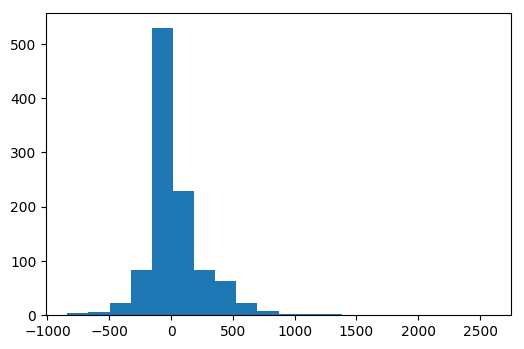

In [30]:
plt.hist(delay_df['departure_delay'], bins=20);

In [33]:
from scipy.stats import mode

In [34]:
np.unique(delay_df.stopId).size

860

In [35]:
mode(delay_df.stopId)

ModeResult(mode=array([10929]), count=array([7]))

In [36]:
pd.value_counts(delay_df.stopId)

10929    7
5593     5
11805    5
11270    5
10706    5
6456     5
6467     5
6197     5
6578     5
11638    4
8649     4
8324     4
76       4
1856     4
8283     4
11252    4
95       4
1907     3
9487     3
5042     3
7096     3
80       3
11499    3
5815     3
3023     3
423      3
6572     3
4242     3
6914     3
386      3
        ..
1176     1
1173     1
1171     1
5266     1
11409    1
1237     1
11478    1
3731     1
11526    1
12172    1
1308     1
1301     1
9486     1
6482     1
7434     1
9481     1
7432     1
11527    1
11523    1
3296     1
11519    1
5370     1
9464     1
8740     1
11501    1
5352     1
1254     1
9445     1
1250     1
4096     1
Name: stopId, Length: 860, dtype: int64

# Potential Questions

Compute the distribution of the delays. 
 * What would you expect the distribution to be? 
 * How far is it from being a normal distribution? 
 * What route has the most delays? 
 * What stop is the worst for delays? (How are you measuring "worst"?)

